## Let's Get to it!

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from project_5 import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
import matplotlib.image as mpimg
import time
from moviepy.editor import VideoFileClip


/Users/jmack/anaconda/envs/carnd-term1/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


First we load the two sets of images.

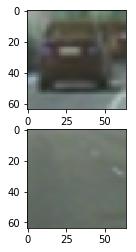

In [2]:
%autoreload 2

sample_vehicle = 'vehicles/GTI_FAR/image0000.png'
sample_non_vehicle = 'non-vehicles/GTI/image1.png'

vehicle_img = cv2.imread(sample_vehicle)
non_vehicle_img = cv2.imread(sample_non_vehicle)

plt.subplot(2,1,1)
plt.imshow(vehicle_img)
plt.subplot(2,1,2)
plt.imshow(non_vehicle_img)
plt.show()

Number of cars:
8792
Number of Non Cars:
8968


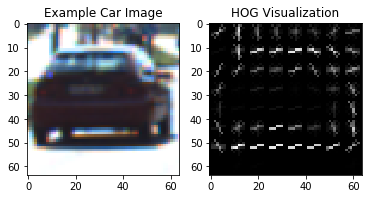

In [3]:
%autoreload 2

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
from skimage.feature import hog

# Read in our vehicles and non-vehicles
cars = glob.glob('vehicles/*/*.png')
notcars = glob.glob('non-vehicles/*/*.png')

print("Number of cars:")
print(len(cars))
print("Number of Non Cars:")
print(len(notcars))

# Generate a random index to look at a car image
ind = np.random.randint(0, len(cars))
# Read in the image
image = mpimg.imread(cars[ind])
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2
# Call our function with vis=True to see an image output
features, hog_image = project_5.get_hog_features(gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(image, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')
plt.show()

In [4]:
'''
%autoreload 2

# Read in car and non-car images
cars = glob.glob('vehicles/*/*.png')
notcars = glob.glob('non-vehicles/*/*.png')

# TODO play with these values to see how your classifier
# performs under different binning scenarios
spatial = 32
histbin = 32

car_features = extract_features(cars, color_space='RGB', spatial_size=(spatial, spatial),
                        hist_bins=histbin, hist_range=(0, 256))
notcar_features = extract_features(notcars, color_space='RGB', spatial_size=(spatial, spatial),
                        hist_bins=histbin, hist_range=(0, 256))

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using spatial binning of:',spatial,
    'and', histbin,'histogram bins')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')
'''


"\n%autoreload 2\n\n# Read in car and non-car images\ncars = glob.glob('vehicles/*/*.png')\nnotcars = glob.glob('non-vehicles/*/*.png')\n\n# TODO play with these values to see how your classifier\n# performs under different binning scenarios\nspatial = 32\nhistbin = 32\n\ncar_features = extract_features(cars, color_space='RGB', spatial_size=(spatial, spatial),\n                        hist_bins=histbin, hist_range=(0, 256))\nnotcar_features = extract_features(notcars, color_space='RGB', spatial_size=(spatial, spatial),\n                        hist_bins=histbin, hist_range=(0, 256))\n\n# Create an array stack of feature vectors\nX = np.vstack((car_features, notcar_features)).astype(np.float64)                        \n# Fit a per-column scaler\nX_scaler = StandardScaler().fit(X)\n# Apply the scaler to X\nscaled_X = X_scaler.transform(X)\n\n# Define the labels vector\ny = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))\n\n\n# Split up data into randomized trainin

In [5]:
%autoreload 2

### TODO: Tweak these parameters and see how the results change.
colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"

print("Thinking")
t=time.time()
car_features = project_5.extract_features(cars, color_space=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
notcar_features = project_5.extract_features(notcars, color_space=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Thinking
83.36 Seconds to extract HOG features...
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460
9.93 Seconds to train SVC...
Test Accuracy of SVC =  0.9921
My SVC predicts:  [ 0.  0.  1.  0.  1.  1.  0.  0.  0.  0.]
For these 10 labels:  [ 0.  0.  1.  0.  1.  1.  0.  0.  0.  0.]
0.00418 Seconds to predict 10 labels with SVC


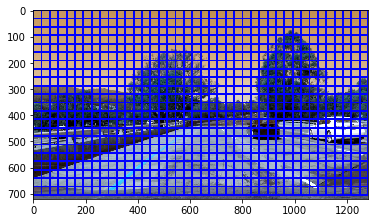

In [6]:
%autoreload 2

image = cv2.imread('test_images/test1.jpg')
windows = project_5.slide_window(image, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(128, 128), xy_overlap=(0.75, 0.75))
                       
window_img = project_5.draw_boxes(image, windows, color=(0, 0, 255), thick=6)                    
plt.imshow(window_img)
plt.show()

In [7]:
%autoreload 2
### TODO: Tweak these parameters and see how the results change.
color_space = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11  # HOG orientations
pix_per_cell = 16 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [300, 700] # Min and max in y to search in slide_window()

# Read in car and non-car images
cars = glob.glob('vehicles/*/*.png')
notcars = glob.glob('non-vehicles/*/*.png')

# Reduce the sample size because
# The quiz evaluator times out after 13s of CPU time
'''
sample_size = 500
cars = cars[0:sample_size]
notcars = notcars[0:sample_size]
'''


print('Getting Features')
t=time.time()


car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to get features...')
t=time.time()
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to get features...')
print("This stage complete")

Getting Features
33.11 Seconds to get features...
32.43 Seconds to get features...
This stage complete


Using: 11 orientations 16 pixels per cell and 2 cells per block
Feature vector length: 4356
6.04 Seconds to train SVC...
Test Accuracy of SVC =  0.989
[((816, 372), (912, 468)), ((1128, 372), (1224, 468)), ((792, 396), (888, 492)), ((816, 396), (912, 492)), ((840, 396), (936, 492)), ((864, 396), (960, 492)), ((1032, 396), (1128, 492)), ((1104, 396), (1200, 492)), ((1128, 396), (1224, 492)), ((1152, 396), (1248, 492)), ((816, 420), (912, 516)), ((840, 420), (936, 516)), ((864, 420), (960, 516)), ((1056, 420), (1152, 516)), ((1080, 420), (1176, 516)), ((1104, 420), (1200, 516)), ((1128, 420), (1224, 516)), ((1152, 420), (1248, 516)), ((1176, 420), (1272, 516))]


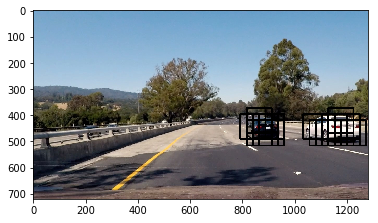

In [8]:
%autoreload 2

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC(C=0.08, penalty='l2', loss='hinge')

# Check the training time for the SVC
t=time.time()

svc.fit(X_train, y_train)

t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

image = mpimg.imread('test_images/test4.jpg')
draw_image = np.copy(image)

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
image = image.astype(np.float32)/255

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(96, 96), xy_overlap=(0.75, 0.75))

hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

print(hot_windows)

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 0), thick=6)                    

plt.imshow(window_img)
%autoreload 2
plt.show()

In [9]:
%autoreload 2
from project_5 import *

image = mpimg.imread('test_images/test1.jpg')
#image = cv2.imread('test_images/test1.jpg')
image = image.astype(np.float32)/255
ystart = 400
ystop = 656
scale = 1.5
    
hot_windows = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
print(hot_windows)

[((816, 400), (912, 496)), ((864, 400), (960, 496)), ((1104, 400), (1200, 496))]


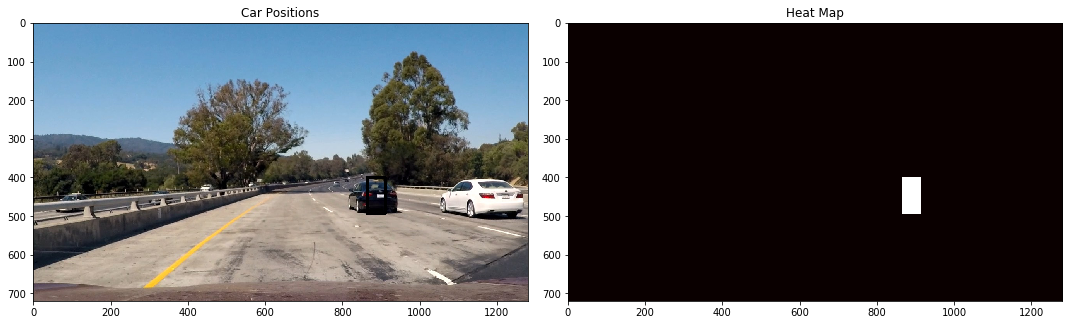

In [10]:
%autoreload 2
from project_5 import *

box_list = hot_windows


# Read in image similar to one shown above 
heat = np.zeros_like(image[:,:,0]).astype(np.float)
# Add heat to each box in box list
heat = add_heat(heat,box_list)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)

fig = plt.figure(figsize=(15, 12))
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()
plt.show()

In [15]:
%autoreload 2

from project_5 import *

output_file = './processed_project_video.mp4'
input_file = './shorter_project_video.mp4'
#input_file = './project_video.mp4'

clip = VideoFileClip(input_file)
vehicleFinder = VehicleFinder(svc = svc, X_scaler = X_scaler)
out_clip = clip.fl_image(vehicleFinder.find) 
out_clip.write_videofile(output_file, audio=False)

[MoviePy] >>>> Building video ./processed_project_video.mp4
[MoviePy] Writing video ./processed_project_video.mp4




  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 1/281 [00:00<01:15,  3.71it/s]

  1%|          | 2/281 [00:00<01:15,  3.71it/s]

  1%|          | 3/281 [00:00<01:15,  3.68it/s]

  1%|▏         | 4/281 [00:01<01:15,  3.66it/s]

  2%|▏         | 5/281 [00:01<01:17,  3.56it/s]

  2%|▏         | 6/281 [00:01<01:18,  3.48it/s]

  2%|▏         | 7/281 [00:01<01:19,  3.43it/s]

  3%|▎         | 8/281 [00:02<01:20,  3.38it/s]

  3%|▎         | 9/281 [00:02<01:23,  3.26it/s]

  4%|▎         | 10/281 [00:02<01:24,  3.22it/s]

  4%|▍         | 11/281 [00:03<01:26,  3.12it/s]

  4%|▍         | 12/281 [00:03<01:27,  3.07it/s]

  5%|▍         | 13/281 [00:03<01:29,  2.98it/s]

  5%|▍         | 14/281 [00:04<01:30,  2.95it/s]

  5%|▌         | 15/281 [00:04<01:32,  2.87it/s]

  6%|▌         | 16/281 [00:05<01:33,  2.84it/s]

  6%|▌         | 17/281 [00:05<01:35,  2.76it/s]

  6%|▋         | 18/281 [00:05<01:37,  2.70it/s]

  7%|▋         | 19/281 [00:06<01:37,  2.67it/s]

  7%|▋         |

[MoviePy] Done.
[MoviePy] >>>> Video ready: ./processed_project_video.mp4 

